# DBSCAN

**DBSCAN** is a clustering method that tries to identify and ignore outlier points that don't fit in well with any clusters. One of its big advantages is that it can create clusters of any shape, rather than preferring spherical blobs like $k$-means.

The algorithm has two hyperparameters: a neighborhood radius $\epsilon > 0$, and a minimum neighbor count $N_\text{min}$. Each sample point has a **neighborhood** consisting of all the points (including itself) that are within distance $\epsilon$ of it. All the neighborhoods that contain fewer than $N_\text{min}$ points are ignored for the rest of the algorithm. The points that have qualifying neighborhoods are known as **core points**.

From each core point, we define its set of **reachable** points by including all of its neighbors, then all the neighbors of the core points that were added, and so on, recursively. That is, both core and non-core points can be reachable, but only the reachable core points have neighborhoods whose contents are also reachable. 

Select a core point, and assign it and all the points reachable from it to a new cluster. Repeat with an unassigned core point, etc., until all core points have been assigned to a cluster. Points that remain are not reachable from any core point and are called **noise points**. They are not considered to be part of any cluster, which is a unique feature of DBSCAN. The rest of the non-core points are sometimes known as **border points**.

<!-- If $p$ and $q$ are core points and $q$ is reachable from $p$, then $p$ is reachable from $q$ also. However, reachability is not symmetric for non-core points (non-core points can't reach anything but themselves). -->
<!-- 

Finally, we say that two points are **connected** if there exists a core point from which they are both reachable. This is the relationship used to define clusters. Select a core point, and assign it and all the points connected to it to a new cluster. Repeat with an unassigned core point, etc., until all points have been assigned to a cluster. -->

::::{prf:example}
:label: example-dbscan-toy
Here is a distance matrix for six sample points $\bfx_1,\ldots,\bfx_6$:

$$
\left[
\begin{array}{cccccc}
0 & \sqrt{8} & \sqrt{7} & \sqrt{3} & \sqrt{5} & \sqrt{11} \\
\sqrt{8} & 0 & \sqrt{12} & \sqrt{14} & \sqrt{12} & \sqrt{10} \\
\sqrt{7} & \sqrt{12} & 0 & \sqrt{10} & \sqrt{10} & \sqrt{8} \\
\sqrt{3} & \sqrt{14} & \sqrt{10} & 0 & \sqrt{3} & \sqrt{12} \\
\sqrt{5} & \sqrt{12} & \sqrt{10} & \sqrt{3} & 0 & \sqrt{3} \\
\sqrt{11} & \sqrt{10} & \sqrt{8} & \sqrt{12} & \sqrt{10} & 0 \\
\end{array}
\right]
$$

Find the DBSCAN clustering for (a) $\epsilon=2,\, N_\text{min}=2$, and (b) $\epsilon=3,\, N_\text{min}=5$. (Always select the lowest-numbered available core point for a new cluster.)

:::{dropdown} Solution
(a) The initial neighborhoods are (by index sets)

$$
1:\{1,4\},\, 2:\{2\}, 3:\{3\}, 4:\{1,4,5\},\, 5:\{4,5,6\}, 6:\{6\}. 
$$

Hence points 1, 4, and 5 are core points. Starting from point 1, 4 is reachable, and then 5 is reachable too, and then 6 is reachable. So the only cluster is $\{1,4,5,6\}$, where 6 is a border point. Points 2 and 3 are noise points.

(b) The initial neighborhoods are now

$$
1:\{1,2,3,4,5\},\, 2:\{1,2\}, 3:\{1,3,6\}, 4:\{1,4,5\},\, 5:\{1,4,5,6\}, 6:\{3,6\}. 
$$

Hence 1 is the only core point. It brings 2, 3, 4, and 5 into the lone cluster, but as border points, they cannot add to it. So 6 is a noise point.
:::
::::

## Properties

For core points, reachability is a symmetric relationship ($p$ is reachable from $q$ if and only if $q$ is reachable from $p$). As a result, a core points always end up in a cluster with all of its reachable core points. But the cluster assignments of the border points can depend on the order in which core points are processed. 

Increasing $N_\text{min}$ helps to avoid having many small clusters, but it might also decrease the total number of core points. If the neighborhood radius $\epsilon$ is chosen too small, the algorithm is too picky—most points will end up as noise. If it's too large, then one tends to obtain a single mega-cluster. There are heuristics for trying to guess an optimal $\epsilon$, but it's frequently necessary to iterate over multiple values.[^optics]

[^optics]: The OPTICS algorithm attempts to address the $\epsilon$ issue by, in effect, analyzing the data just once for all $\epsilon$ simultaneously.

## Toy example

Here is a challenging artificial sample set: a blob of 200 points in the middle, with 300 points in a ring around it.

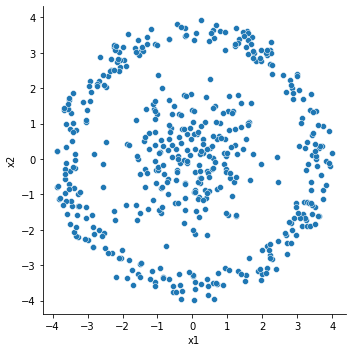

In [1]:
from numpy.random import default_rng
import numpy as np
import pandas as pd
import seaborn as sns

rng = default_rng(6)
inner = rng.normal(size=(200,2))
theta = rng.uniform(0,2*np.pi,size=300)
r = rng.uniform(3.2,4,size=300)
outer = np.vstack((r*np.cos(theta),r*np.sin(theta))).T

df = pd.DataFrame(np.vstack((inner,outer)),columns=["x1","x2"])
sns.relplot(data=df,x="x1",y="x2");

We start by computing all the pairwise distances between points.

In [2]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(df,metric="euclidean")

For any value of $\epsilon$, we can find the entries in each row of the distance matrix that are no greater than $\epsilon$.

In [3]:
def get_neighbors(D,eps):
    return [ np.where(row <= eps)[0] for row in D ]

If $\epsilon$ is small enough, most points will have only themselves as neighborhoods.

In [4]:
nbrs = get_neighbors(D,0.02)
print(nbrs[:6])

[array([0]), array([1]), array([2]), array([3]), array([4]), array([5])]


In [5]:
N = [ len(n) for n in nbrs ]
print("neighborhood sizes for eps=0.02:")
print(pd.Series(N).value_counts())

neighborhood sizes for eps=0.02:
1    488
2     12
dtype: int64


As a result, there can be at most 12 clusters if $N_\text{min}>1$, and most points will be noise points. We can check this using the `DBSCAN` clusterer.

In [6]:
from sklearn.cluster import DBSCAN
dbs = DBSCAN(eps=0.02,min_samples=2)
dbs.fit(df)

DBSCAN(eps=0.02, min_samples=2)

A `DBSCAN` object has a `labels_` property with cluster assignments, just like other cluster objects. But a cluster assignment `-1` indicates a noise point. The number of clusters, then, is one less than the number of unique values in the assignment vector.

In [7]:
y = pd.Series(dbs.labels_)
print("epsilon=0.02:",sum(y==-1),"noise points,",sum(y.unique()!=-1),"clusters")

epsilon=0.02: 488 noise points, 6 clusters


If $\epsilon$ is sufficiently large, on the other hand, the neighborhoods of the points are so large that they each contain many points.

neighborhood sizes for eps=2:


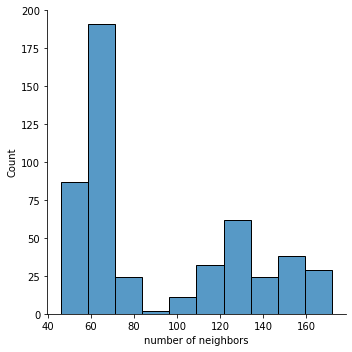

In [8]:
nbrs = get_neighbors(D,2)
N = [ len(n) for n in nbrs ]
print("neighborhood sizes for eps=2:")
sns.displot(x=pd.Series(N,name="number of neighbors"));

So for $N_\text{min}=40$, say, every point will be a core point. The neighborhoods overlap so much that they all end up in a single cluster:

In [9]:
dbs = DBSCAN(eps=2,min_samples=40)
dbs.fit(df)
y = pd.Series(dbs.labels_)
print("epsilon=2:",sum(y==-1),"noise points,",sum(y.unique()!=-1),"clusters")

epsilon=2: 0 noise points, 1 clusters


In between, most points belong to one of the two natural clusters.

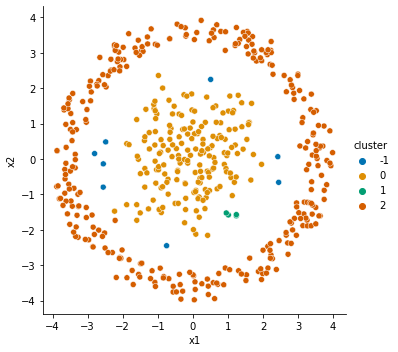

In [10]:
dbs = DBSCAN(eps=0.5,min_samples=4)
dbs.fit(df)
df["cluster"] = pd.Series(dbs.labels_)
sns.relplot(data=df,x="x1",y="x2",hue="cluster",palette="colorblind");

We can convert some of the tiny clusters above into noise points by adjusting $N_\text{min}$.

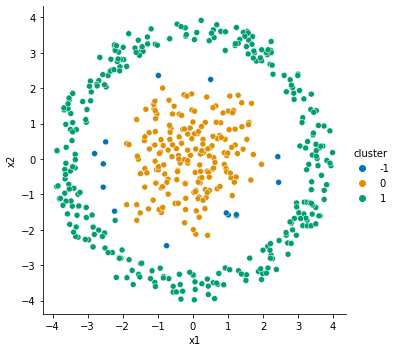

In [11]:
dbs = DBSCAN(eps=0.5,min_samples=5)
dbs.fit(df)
df["cluster"] = pd.Series(dbs.labels_)
sns.relplot(data=df,x="x1",y="x2",hue="cluster",palette="colorblind");

<!-- 
A fitted DBSCAN clusterer has a property `core_sample_indices_` that holds the indices of all the core points. We use that here to find and highlight the border points.

```{code-cell} ipython3
df["is_core"] = False    # create a column of Falses
df.loc[dbs.core_sample_indices_,"is_core"] = True
df["is_border"] = ~(df["is_core"]) & (df["cluster"]!=-1)   # not core and not noise
sns.relplot(data=df,x="x1",y="x2",style="cluster",hue="is_border",palette="colorblind");
``` 
-->

## Case study: digits

We return to the handwritten digits data, keeping only the written 4s, 5s, and 6s.

In [12]:
from sklearn import datasets
digits = datasets.load_digits(as_frame=True)["frame"]
digits = digits.loc[digits["target"].isin([4,5,6])]
X = digits.drop("target",axis=1)
X.index = range(len(X))
y = digits.target
y.value_counts()

5    182
4    181
6    181
Name: target, dtype: int64

Without a good sense for optimal hyperparameters, we do a quick search over $\epsilon$. We want to simulate not having any ground truth labels, but silhouette score is a bit tricky to use with DBSCAN because of the noise samples. Noise points aren't meant to be a cluster, so including them in the score can be misleading. In the following experiment, we leave out the noise points when calculating the mean silhouette score, and record the numbers of clusters and noise points as well.

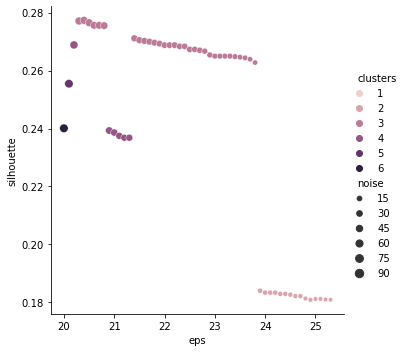

In [13]:
from sklearn.metrics import silhouette_score,silhouette_samples
results = []
for eps in np.arange(20,26,0.1):
    dbs = DBSCAN(eps=eps,min_samples=4)
    dbs.fit(X)
    c = pd.Series(dbs.labels_)
    noise = c==-1
    k = max(c) + 1  # the number of clusters
    if k==1:
        # This would cause an error in silhouette_score.
        sil = np.NaN   
    else:
        # Exclude noise points from silhouette values.
        sil = silhouette_score(X.loc[~noise],c[~noise])
    results.append([eps,k,sum(c==-1),sil]) 

results = pd.DataFrame(results,columns=["eps","clusters","noise","silhouette"]) 
sns.relplot(data=results,x="eps",y="silhouette",hue="clusters",size="noise");

As always, increasing $\epsilon$ tends to decrease $k$ (the number of clusters) and the number of noise points. The longest stretch has $k=3$, and transitions to 4 and 2 clusters are marked by downward jumps in the mean silhouette. These observations support choosing $k=3$, which we know to be ideal in this dataset. The slow decrease in silhouettes as $\epsilon$ increases is due to former noise points being assigned to clusters; since they fit more poorly than the average cluster member, the mean score decreases. We will favor having as few noise points as possible when $k=3$.

In [14]:
# Limit the scope to k=3:
results = results.loc[results["clusters"]==3]  
# Find the row with minimum noise point count:
i_best = results["noise"].argmin()
eps_best = results["eps"].iloc[i_best]
print("best eps:",eps_best)

best eps: 23.800000000000054


In [15]:
dbs = DBSCAN(eps=eps_best,min_samples=4)
dbs.fit(X)
y_hat = pd.Series(dbs.labels_,index=y.index)
y_hat.value_counts()

 1    179
 2    172
 0    170
-1     23
dtype: int64

The three clusters have nearly equal size, which reflects the dataset well. We can compare to the true labels via the Rand score:

In [16]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(y,y_hat)

0.9304246793248612

Let's take a look at some of the samples that were labeled as noise.

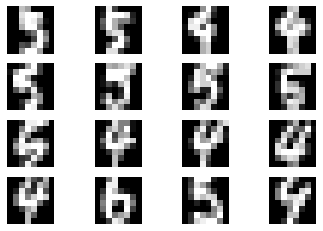

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Given feature matrix, plot first 16 rows as 8x8 gray images in a grid.
def plot_digits(X):
    fig, axes = plt.subplots(4,4)
    for i in range(4):
        for j in range(4):
            row = j + 4*i
            A = np.reshape(np.array(X.iloc[row,:]),(8,8))
            sns.heatmap(A,ax=axes[i,j],square=True,cmap="gray",cbar=False)
            axes[i,j].axis(False)
    return None

# Plot some noise cases.
plot_digits(X[dbs.labels_==-1])

Some of these images are ambiguous to a human as well, but in other cases the failure to be clustered with the right class is harder to explain immediately.

<div style="max-width:608px"><div style="position:relative;padding-bottom:66.118421052632%"><iframe id="kaltura_player" src="https://cdnapisec.kaltura.com/p/2358381/sp/235838100/embedIframeJs/uiconf_id/43030021/partner_id/2358381?iframeembed=true&playerId=kaltura_player&entry_id=1_8w2ld5o2&flashvars[streamerType]=auto&amp;flashvars[localizationCode]=en&amp;flashvars[leadWithHTML5]=true&amp;flashvars[sideBarContainer.plugin]=true&amp;flashvars[sideBarContainer.position]=left&amp;flashvars[sideBarContainer.clickToClose]=true&amp;flashvars[chapters.plugin]=true&amp;flashvars[chapters.layout]=vertical&amp;flashvars[chapters.thumbnailRotator]=false&amp;flashvars[streamSelector.plugin]=true&amp;flashvars[EmbedPlayer.SpinnerTarget]=videoHolder&amp;flashvars[dualScreen.plugin]=true&amp;flashvars[Kaltura.addCrossoriginToIframe]=true&amp;&wid=1_o0nn809i" width="608" height="402" allowfullscreen webkitallowfullscreen mozAllowFullScreen allow="autoplay *; fullscreen *; encrypted-media *" sandbox="allow-forms allow-same-origin allow-scripts allow-top-navigation allow-pointer-lock allow-popups allow-modals allow-orientation-lock allow-popups-to-escape-sandbox allow-presentation allow-top-navigation-by-user-activation" frameborder="0" title="Kaltura Player" style="position:absolute;top:0;left:0;width:100%;height:100%"></iframe></div></div>